In [194]:
import json
from typing  import List 


constants and variables

In [195]:
RAWOCR_LIBRARY = 'rawocr2.json'
test_img = '20220701_130254.jpg'
success = {}

In [196]:
from IPython.display import Image

path = '../ergImages' + "/" + test_img

# Display the image in the notebook
# Image(filename=path)

Get raw ocr data

In [197]:
def open_rawocr(file_path=RAWOCR_LIBRARY) -> dict:
    with open(file_path, "r") as f:
        raw_ocr_responses = json.load(f)
    return raw_ocr_responses

full_raw_data = open_rawocr()

In [198]:
#Image Names
image_names = full_raw_data.keys()
print(image_names)

dict_keys(['ss2kAtomicIndoors.png', '20220910_091313.jpg', '20220910_091104.jpg', '20220910_091514.jpg', '20220920_134444.jpg', 'IMG_0761.jpg', '20220128_111508.jpg', '20220701_142257.jpg', '20220701_132613.jpg', '20220910_091506.jpg', '20220701_142337.jpg', '20220701_130328.jpg', '20220701_142153.jpg', '20220701_124217.jpg', 'IMG_0049.jpg', 'ss4x12minBlur.png', '20220701_142236.jpg', '20220910_091412.jpg', '20220913_134115.jpg', '20220701_135452.jpg', '20220919_130840.jpg', '20220701_135532.jpg', 'ss3x4000mA.png', '20220701_132843.jpg', 'ss6x15min.png', '20220701_130254.jpg', '20220910_101152.jpg', '20220701_132654.jpg', '20220701_132534.jpg', '20220910_091546.jpg', '20220701_124150.jpg', '20220701_135315.jpg', 'IMG_0286.jpg', 'ss6x15A.png', '20220701_132527.jpg', '20220701_132756.jpg', '20220910_091133.jpg', '20220701_130356.jpg', 'ss4x12minA.png', '20220701_124122.jpg', '20220910_091247.jpg', 'IMG_1856.jpg', '20220701_130221.jpg', '20220701_135017.jpg', '20220910_091323.jpg', '20220

##  What  am I trying to do
I want to create table data that has four columns (time, meter, split, sr) 
I need to know the number of columns in the returned table so that I can adust it if needed to have four
* find table dimensions by looking at the last CELL block column index
For now HR is ignored 

Sometimes the workout name and date are being included in the table eitherr as headings or as cells. This is bad
* The first cell in the table data should include the word 'time'. 
* Generate table_data list[dict] then delete all dicts before 'time' in text 
* this will cause an errorr rif the ocr didn't extract 'time' correctly but I think this is very unusual 

In [224]:

def create_word_index(image_raw_response:dict)->dict:
    # create dict {word_id : word_text}
    word_blocks: List[dict] = [block for block in image_raw_response['Blocks'] if block['BlockType'] == 'WORD']
    word_index = {}
    for block in word_blocks:
        word_index[block["Id"]] = block["Text"]
    return word_index

def extract_table_data(image_raw_response: dict, word_index:dict) -> List[dict]:
    # check num_cols then create table_data
    cell_blocks: List[dict] = [block for block in image_raw_response['Blocks'] if block['BlockType'] == 'CELL']
    num_cols =  cell_blocks[-1]['ColumnIndex']
    print(f'num cols: {num_cols}')
    if not 3 < num_cols < 6: 
        return (False, 'invalid column count')
    table_data = []
    for block in cell_blocks:
        #  if cell is empty, add empty entry. Ignore HR column. 
        if not "Relationships" in block.keys() and block['ColumnIndex'] < 5:
            # if previous block didn't corect empty cell, add empty entry - see FIX  below
            if not (table_data[-1]['row'] == block['RowIndex'] and table_data[-1]['col'] == block['ColumnIndex']):
                cell_data = {"row": block["RowIndex"], "col": block["ColumnIndex"], "text": [""]}
                table_data.append(cell_data)       
        # deal with cells in columns 1-4 that have content
        elif "Relationships" in block.keys():
            cell_data = {"row": None, "col": None, "text": [], 'text_ids':[]}
            cell_data["row"] = block["RowIndex"]
            cell_data["col"] = block["ColumnIndex"]
            for word_id in block["Relationships"][0]["Ids"]:
                cell_data["text_ids"].append(word_id)
            for word_id in cell_data["text_ids"]:
                cell_data["text"].append(word_index[word_id])
            table_data.append(cell_data)
            # FIX for when stroke rate gets lumped in with split but still recognized as two words
            if (block["ColumnIndex"] == 3 and len(cell_data["text_ids"]) > 1):
                table_data.append(
                    {
                        "row": block["RowIndex"],
                        "col": 4,
                        "text": [word_index[cell_data["text_ids"][-1]]],
                        "text_id": [cell_data["text_ids"][-1]],
                    }
                )
    # print(table_data)
    return table_data

In [226]:
table_data_extracted = extract_table_data(full_raw_data[test_img], create_word_index(full_raw_data[test_img]))
table_data_extracted

num cols: 4


[{'row': 1,
  'col': 1,
  'text': ['View', 'Detail'],
  'text_ids': ['51caf324-e576-4d21-8b19-79659b01c318',
   '86faf489-e267-4fe3-97ec-b315f691962a']},
 {'row': 1, 'col': 2, 'text': ['']},
 {'row': 1, 'col': 3, 'text': ['']},
 {'row': 1, 'col': 4, 'text': ['']},
 {'row': 2,
  'col': 1,
  'text': ['2000m'],
  'text_ids': ['90a41cfc-ed02-4e81-a659-b0ff2d5e8cfe']},
 {'row': 2, 'col': 2, 'text': ['']},
 {'row': 2, 'col': 3, 'text': ['']},
 {'row': 2, 'col': 4, 'text': ['']},
 {'row': 3,
  'col': 1,
  'text': ['Jul', '01', '2022', 'time'],
  'text_ids': ['3f68c835-2cad-4faf-9869-59dd04c4a2d8',
   'f20d35f0-8578-4026-bd03-5f753dc9a9b3',
   'd20d9216-1307-4e1e-a0a3-48cb0b32b2ae',
   '2790739f-f881-4c3f-baf4-2aa26c2394fa']},
 {'row': 3,
  'col': 2,
  'text': ['meter'],
  'text_ids': ['35e07970-9f47-4703-8579-94f58af831b8']},
 {'row': 3,
  'col': 3,
  'text': ['500m', '5/10'],
  'text_ids': ['76f0910b-6729-4aab-999c-9f111f3277de',
   'a34dbd00-2f18-472a-a389-a3ce16fc219a']},
 {'row': 3,
  'co

In [219]:
def clean_table_data(table_data: List[dict]):
    # remove all cells before 'time' 
    while 'time' not in table_data[0]['text']:
        del table_data[0]
    table_data[0]["text"] = ["time"]
    table_data[1]["text"] = ["meter"]
    table_data[2]["text"] = ["split"]
    table_data[3]["text"] = ["sr"]
    for cell in table_data:
        for word in cell["text"]:
            if "," in word:
                word_index = cell["text"].index(word)
                cell["text"][word_index] = word.replace(",", ".")
    return table_data

table_data_extracted = extract_table_data(full_raw_data[test_img])
print('extracted table data', table_data_extracted)
table_data_clean = clean_table_data(table_data_extracted) 
table_data_clean

num cols: 4
extracted table data [{'row': 1, 'col': 1, 'text': ['View', 'Detail'], 'text_ids': ['51caf324-e576-4d21-8b19-79659b01c318', '86faf489-e267-4fe3-97ec-b315f691962a']}, {'row': 1, 'col': 2, 'text': ['']}, {'row': 1, 'col': 3, 'text': ['']}, {'row': 1, 'col': 4, 'text': ['']}, {'row': 2, 'col': 1, 'text': ['2000m'], 'text_ids': ['90a41cfc-ed02-4e81-a659-b0ff2d5e8cfe']}, {'row': 2, 'col': 2, 'text': ['']}, {'row': 2, 'col': 3, 'text': ['']}, {'row': 2, 'col': 4, 'text': ['']}, {'row': 3, 'col': 1, 'text': ['Jul', '01', '2022', 'time'], 'text_ids': ['3f68c835-2cad-4faf-9869-59dd04c4a2d8', 'f20d35f0-8578-4026-bd03-5f753dc9a9b3', 'd20d9216-1307-4e1e-a0a3-48cb0b32b2ae', '2790739f-f881-4c3f-baf4-2aa26c2394fa']}, {'row': 3, 'col': 2, 'text': ['meter'], 'text_ids': ['35e07970-9f47-4703-8579-94f58af831b8']}, {'row': 3, 'col': 3, 'text': ['500m', '5/10'], 'text_ids': ['76f0910b-6729-4aab-999c-9f111f3277de', 'a34dbd00-2f18-472a-a389-a3ce16fc219a']}, {'row': 3, 'col': 4, 'text': ['5/10'], 

[{'row': 3,
  'col': 1,
  'text': ['time'],
  'text_ids': ['3f68c835-2cad-4faf-9869-59dd04c4a2d8',
   'f20d35f0-8578-4026-bd03-5f753dc9a9b3',
   'd20d9216-1307-4e1e-a0a3-48cb0b32b2ae',
   '2790739f-f881-4c3f-baf4-2aa26c2394fa']},
 {'row': 3,
  'col': 2,
  'text': ['meter'],
  'text_ids': ['35e07970-9f47-4703-8579-94f58af831b8']},
 {'row': 3,
  'col': 3,
  'text': ['split'],
  'text_ids': ['76f0910b-6729-4aab-999c-9f111f3277de',
   'a34dbd00-2f18-472a-a389-a3ce16fc219a']},
 {'row': 3,
  'col': 4,
  'text': ['sr'],
  'text_id': ['a34dbd00-2f18-472a-a389-a3ce16fc219a']},
 {'row': 4,
  'col': 1,
  'text': ['7:38.9'],
  'text_ids': ['40f77f99-9cf6-4b37-aabb-315ea2a724a1']},
 {'row': 4,
  'col': 2,
  'text': ['2000'],
  'text_ids': ['18d8a529-83ee-4a20-bf65-2de68e19762a']},
 {'row': 4,
  'col': 3,
  'text': ['1:54.7', '31'],
  'text_ids': ['00abb28b-6cfb-497d-81a5-f9fd60227dda',
   'e3dd1737-138c-4606-beb0-c7380f5dc982']},
 {'row': 4,
  'col': 4,
  'text': ['31'],
  'text_id': ['e3dd1737-138

In [222]:
# view workout data - visual only
def compile_workout_data(wo_clean: List[dict]) -> dict:
    col_head_row = wo_clean[0]['row']
    wo_dict = {"time": [], "meter": [], "split": [], "sr": []}
    for cell in wo_clean:
        if cell["row"] > col_head_row:
            if cell["col"] == 1:
                wo_dict["time"].append(cell["text"][0])
            elif cell["col"] == 2:
                wo_dict["meter"].append(cell["text"][0])
            elif cell["col"] == 3:
                wo_dict["split"].append(cell["text"][0])
            elif cell["col"] == 4:
                wo_dict["sr"].append(cell["text"][0])
    return wo_dict

workout_data_compiled = compile_workout_data(table_data_clean)
workout_data_compiled

{'time': ['7:38.9', '1:24.3', '1:33.9', '1:34.2', '1:35.1', '1:31.3'],
 'meter': ['2000', '400', '800', '1200', '1600', '2000'],
 'split': ['1:54.7', '1:45.3', '1:57.3', '1:57 7', '1:58.8', '1:54.1'],
 'sr': ['31', '37', '29', '28', '28', '34']}

## Get Metadata

In [228]:
def extract_metadata(word_index:dict, image_raw_response: dict) -> List[str]:
    raw_meta = []
    line_blocks: List[dict] = [block for block in image_raw_response['Blocks'] if block['BlockType'] == 'LINE']
    # find id for word 'time' - beginning of table
    for id, word in word_index.items():
        if word == 'time':
            time_id = id 
    for block in line_blocks:
        if time_id in block["Relationships"][0]["Ids"]: 
            break
        else:
            raw_meta.append(block["Text"])
    return raw_meta

raw_meta = extract_metadata(word_index=create_word_index(full_raw_data[test_img]), image_raw_response=full_raw_data[test_img], table_data_extracted=table_data_extracted  )
raw_meta

['concept 2.', 'PM5', 'View Detail', '2000m', 'Jul 01 2022']

In [229]:

# clean metadata
def clean_metadata(raw_meta: list) -> dict:
    # Delete everything before wo_name
    meta = raw_meta
    try:
        view_detail_idx = [
            i for i, item in enumerate(raw_meta) if "View" in item or "Detail" in item
        ][0]
        meta = raw_meta[view_detail_idx + 1 :]
    except:
        pass
    for i in range(len(meta)):
        try:
            meta[i] = meta[i].replace(",", ".")
        except:
            pass
    if len(meta) == 2:
        meta_dict = {"wo_name": meta[0], "date": meta[1]}
    elif len(meta) >= 4:
        meta_dict = {
            "workout_name": meta[0],
            "total_type": meta[1],
            "workout_date": meta[2],
            "total_val": meta[3],
        }
    return meta_dict

clean_metadata(raw_meta)

{'wo_name': '2000m', 'date': 'Jul 01 2022'}

## Data Play

### What makes a perfect output?

* 4 column headings (5 if HR included) 
* equal number of row entries for each column
    * if it's a interval workout, ignore rest time info
* time: create regex to confirm format
* meter: int
* split: use regex
* sr: int between x and y 
* hr: none or int 
* column headings can be replaced to time, meteer, split, sr,  hr(?)

In [203]:
import re 

def check_meets_requirements(data:dict):
    passed = None
    if not len(data.keys()) in (4,5):
        return (False, 'failed T1 num_cols')
    
    time_rows = len(data['time'])
    meter_rows = len(data['meter'])
    split_rows = len(data['split'])
    sr_rows  = len(data['sr'])
    if not ((time_rows == split_rows == sr_rows) and (meter_rows == time_rows or meter_rows ==  time_rows +1)):
        return (False, 'failed T2 equal rows')

    duration_regex = re.compile(r'((^\d+:)?[0-5]\d:[0-5]\d.\d$)|^[0-5]?\d:[0-5]\d.\d$|^[1-5]\d.\d$')
    meter_regex = re.compile(r'\d+')
    split_regex = re.compile(r'^[1-3]:[0-5]\d.\d$')
    sr_regex = re.compile(r'\d{2}')
    for i in range(time_rows):
        if not duration_regex.match(data['time'][i]):
            return (False,'failed time regex')
        if not meter_regex.match(data['meter'][i]):
            return (False,'failed meter regex')
        if not split_regex.match(data['split'][i]):
            return (False,'failed split regex' )
        if not sr_regex.match(data['sr'][i]):
            return (False,'failed sr regex')
    passed = 'passed num_cols, equal rows and regex matching'
    return (True, passed) 

In [204]:
# put it together 
def sort_successful(full_raw:dict=full_raw_data, image_names:list=image_names):
    success = {}
    fail = {}
    for image in image_names:
        try:
            table_extracted = extract_table_data(full_raw[image])
            try: 
                table_clean = clean_table_data(table_extracted)
                try:
                    compiled = compile_workout_data(table_clean)
                    try:
                        pass_resp = check_meets_requirements(compiled)
                        if pass_resp[0]:
                            success[image] = compiled
                        else:
                            fail[image] = ('failed formatting check', pass_resp)
                    except Exception as e:
                        fail[image] = ('error in check_meets_requirements', e)
                except Exception as e:
                    fail[image] = ('compile_workout_data', e)
            except Exception as e:
                fail[image] = ('clean_table_data', e)
        except Exception as e:
            fail[image] = ('extract_table_data',  e)
    return (success, fail) 

resp  = sort_successful()
successes = resp[0]
fails = resp[1]


            

num cols: 5
num cols: 5
num cols: 5
num cols: 5
num cols: 5
num cols: 5
num cols: 5
num cols: 5
num cols: 4
num cols: 5
num cols: 3
num cols: 4
num cols: 4
num cols: 5
num cols: 5
num cols: 5
num cols: 4
num cols: 5
num cols: 5
{'row': 1, 'col': 1, 'text': ['View', 'Detail'], 'text_ids': ['c77c52ce-eb62-44a3-9e43-10f0a9e55a4f', '25362149-7fe8-475e-98b6-b833ff2714a3']}
{'row': 1, 'col': 3, 'text': ['']}
{'row': 2, 'col': 2, 'text': ['']}
{'row': 3, 'col': 1, 'text': ['']}
{'row': 3, 'col': 3, 'text': ['']}
{'row': 4, 'col': 2, 'text': ['']}
{'row': 5, 'col': 1, 'text': ['']}
{'row': 5, 'col': 3, 'text': ['']}
{'row': 6, 'col': 2, 'text': ['1000'], 'text_ids': ['a21fe9a1-6fa7-402e-9482-11c825a9a7e9']}
{'row': 6, 'col': 4, 'text': ['27'], 'text_id': ['e9304172-1807-49d3-8505-9ef97b70ec14']}
{'row': 7, 'col': 2, 'text': ['1500'], 'text_ids': ['c25df085-5390-4647-a394-7291a27f61d7']}
{'row': 7, 'col': 4, 'text': ['27'], 'text_id': ['c0584ca1-1ff2-4169-a3ae-e3b24c9fccdf']}
{'row': 8, 'col': 

In [205]:
def fail_cause_tally(fails:dict):
    tally = {
        'extract_table_data': [0,[]],
        'clean_table_data':[0,[]],
        'compile_workout_data':[0,[]],
        'wrong col_nums':[0,[]], 
        'rows unequal': [0,[]], 
        'time regex':[0,[]],
        'meter regex':[0,[]],
        'split regex':[0,[]],
        'sr regex':[0,[]],
        }
    for image in fails:
        if fails[image][1] == (False, 'failed T2 equal rows'):
            tally['rows unequal'][0] += 1
            tally['rows unequal'][1].append(image)
        elif fails[image][1] == (False, 'failed time regex'):
            tally['time regex'][0] += 1
            tally['time regex'][1].append(image)
        elif fails[image][1] == (False, 'failed split regex'):
            tally['split regex'][0] += 1
            tally['split regex'][1].append(image)
        else:
            print(image, fails[image])
    return tally
    
fail_causes = fail_cause_tally(fails)
fail_causes

ss2kAtomicIndoors.png ('error in check_meets_requirements', TypeError('expected string or bytes-like object'))
20220910_091313.jpg ('error in check_meets_requirements', TypeError('expected string or bytes-like object'))
20220910_091104.jpg ('extract_table_data', IndexError('list index out of range'))
20220910_091514.jpg ('error in check_meets_requirements', TypeError('expected string or bytes-like object'))
20220920_134444.jpg ('error in check_meets_requirements', TypeError('expected string or bytes-like object'))
IMG_0761.jpg ('error in check_meets_requirements', TypeError('expected string or bytes-like object'))
20220128_111508.jpg ('error in check_meets_requirements', TypeError('expected string or bytes-like object'))
20220701_142257.jpg ('extract_table_data', IndexError('list index out of range'))
20220701_132613.jpg ('error in check_meets_requirements', TypeError('expected string or bytes-like object'))
20220910_091506.jpg ('error in check_meets_requirements', TypeError('expected 

{'extract_table_data': [0, []],
 'clean_table_data': [0, []],
 'compile_workout_data': [0, []],
 'wrong col_nums': [0, []],
 'rows unequal': [2, ['20220701_135452.jpg', '20220701_130254.jpg']],
 'time regex': [0, []],
 'meter regex': [0, []],
 'split regex': [0, []],
 'sr regex': [0, []]}

In [206]:
# resp[1]

In [207]:
for key in resp[1]:
    # print(resp[1][key])

IndentationError: expected an indented block (127030691.py, line 2)

In [ ]:
import re

duration_regex2 = re.compile(r'^((\d+):)?(\d{1,2}):(\d{1,2}\.\d)$|^(\d+):(\d{1,2}):(\d{1,2}\.\d)$|^(\d{1,2}):(\d{1,2}\.\d)$|^(\d+)\.(\d)$')
d = 'hh:mm:ss.t'
duration_regex = re.compile(r'((^\d+:)?[0-5]\d:[0-5]\d.\d$)|^[0-5]?\d:[0-5]\d.\d$|^[1-5]\d.\d$')
test_durations = ['111:22:33.4', '1:11:11.1', '11:11.1','1:11.1','11.1','1.1']

# Example usage
# test_string = "6.7"
for  test_string  in test_durations:
    if duration_regex.match(test_string):
        print("Valid duration")
    else:
        print("Invalid duration")


Valid duration
Valid duration
Valid duration
Valid duration
Valid duration
Invalid duration


In [ ]:
def list_entry_blocktypes(raw_ocr_responses: dict, entry_name: str) -> list:
    blockTypes = []
    blocks = raw_ocr_responses[entry_name]["Blocks"]
    for i in range(len(blocks)):
        if not blocks[i]["BlockType"] in blockTypes:
            blockTypes.append(blocks[i]["BlockType"])
    # print(blockTypes)
    return blockTypes


def list_all_blocktypes(raw_ocr_responses: dict):
    all_block_types = {}
    for image in raw_ocr_responses.keys():
        all_block_types[image] = list_entry_blocktypes(raw_ocr_responses, image)
    return all_block_types

blockTypes = list_all_blocktypes(full_raw_data)
print(blockTypes)

mergTally = 0
entries_with_merges = []
for image in blockTypes:
    if 'MERGED_CELL' in blockTypes[image]:
        mergTally+=1
        entries_with_merges.append(image)
print(mergTally)

# arer the images with merged cells the ones failing on equal rows? 
fail_not_merge = []
for image in fail_causes['rows unequal'][1]:   
    if not image in entries_with_merges:
        fail_not_merge.append(image)
print('Images that failed  on "equal rows" but do not have merged cells')
print(fail_not_merge)
print(len(fail_not_merge))


{'ss2kAtomicIndoors.png': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL', 'TABLE_TITLE'], '20220910_091313.jpg': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL', 'TABLE_TITLE'], '20220910_091104.jpg': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL', 'MERGED_CELL', 'TABLE_TITLE'], '20220910_091514.jpg': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL', 'TABLE_TITLE'], '20220920_134444.jpg': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL', 'TABLE_TITLE'], 'IMG_0761.jpg': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL', 'TABLE_TITLE'], '20220128_111508.jpg': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL', 'TABLE_TITLE'], '20220701_142257.jpg': ['PAGE', 'LINE', 'WORD'], '20220701_132613.jpg': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL'], '20220910_091506.jpg': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL', 'TABLE_TITLE'], '20220701_142337.jpg': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL', 'TABLE_TITLE'], '20220701_130328.jpg': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL', 'MERGED_CELL'], '20220701_142153.jpg': ['PAGE', 'LINE', 'WORD', 'TABLE', 'CELL',

### Questions 

1. What proportion of images process perfectly ?
2. When not perfect, where  is the issue? 
3. What assumptions can I constrain the processing to? 
    * Four (or five) columns 

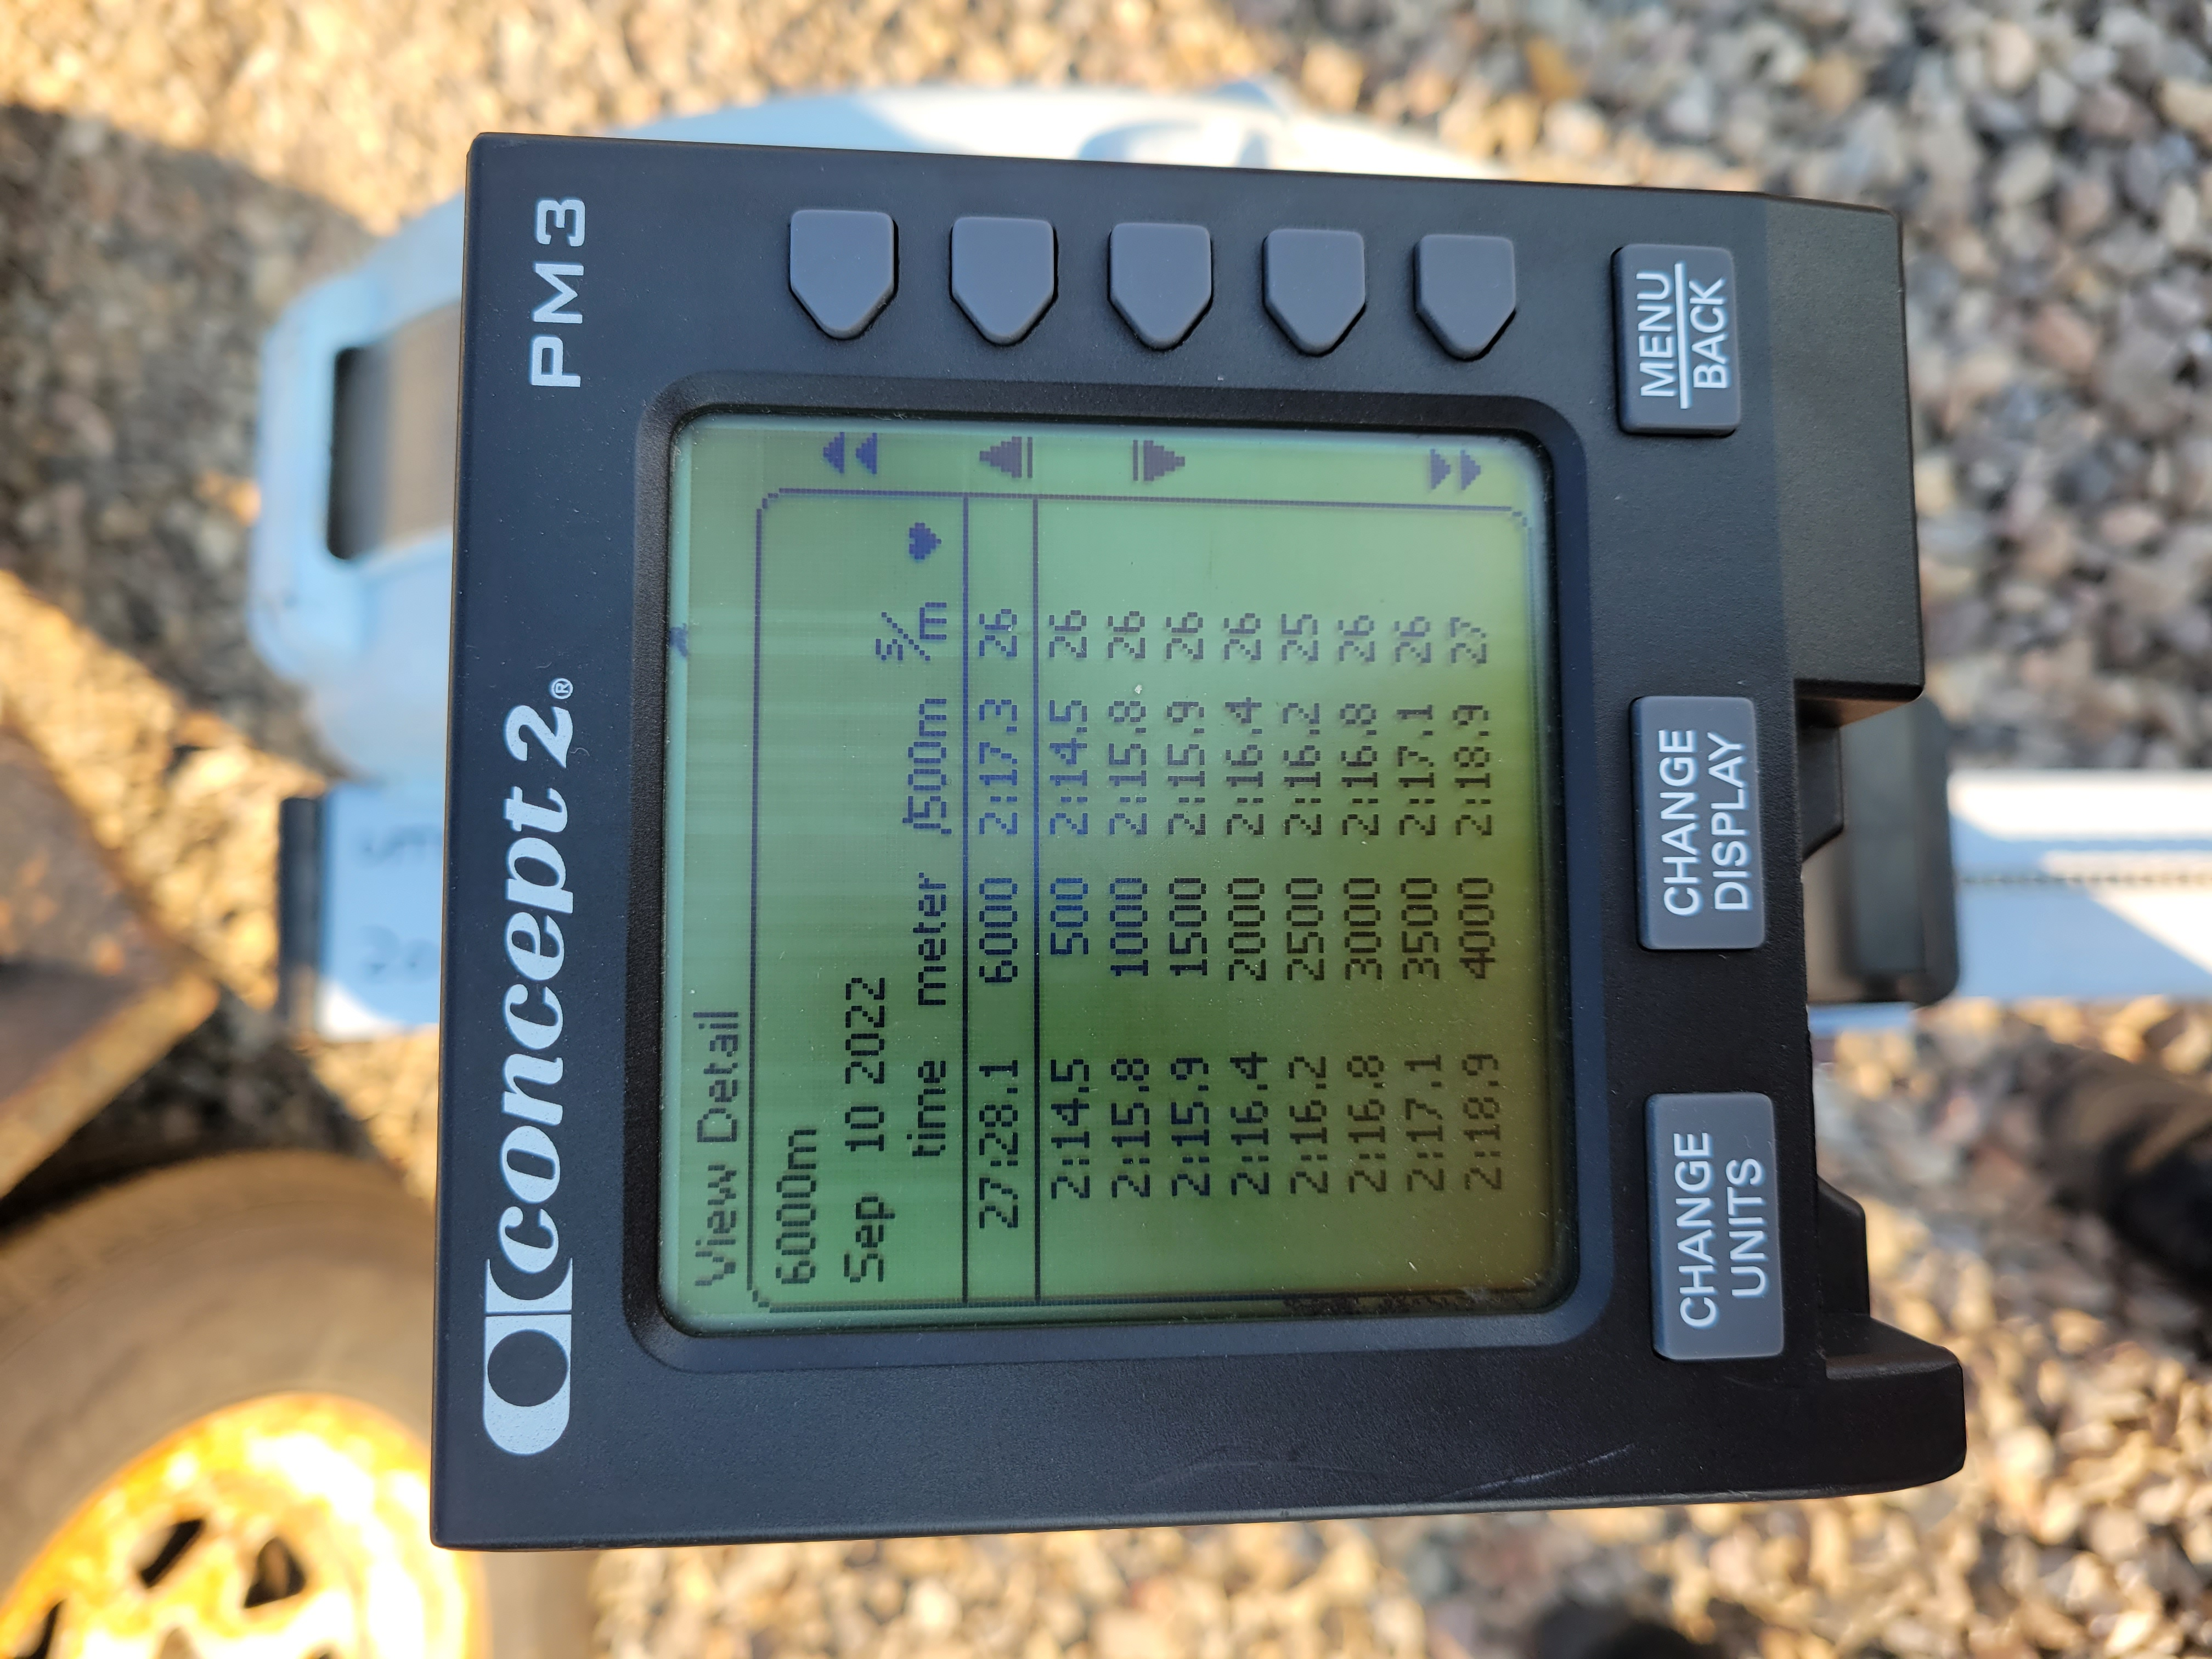

In [ ]:
from IPython.display import Image

image = '20220910_091313.jpg'
path = '../ergImages' + "/" + image

# Display the image in the notebook
Image(filename=path)
